# Modélisation 

### 1. Analyse en Composantes Principales et préparation de la modélisation

Nous réalisons une Analyse en Composantes Principales mutualisée afin de synthétiser l'information et comparer les années entre elles.



In [8]:
# Importation des librairies nécessaires 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import importlib.util
from pathlib import Path
import seaborn as sns
from xgboost import XGBRegressor

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/loane/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <89AD948E-E564-3266-867D-7AF89D6488F0> /Users/loane/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [9]:
# ACP mutualisée 

def compute_pca_all_years(df, pca_cols, n_components=3):
    """
    On regroupe les données de toutes les années pour calculer les composantes principales.
    Cela permet de pouvoir comparer les composantes principales d'une année à l'autre.
    Si l'on avait calculé les composantes principales pour chaque année,
    on aurait obtenu des composantes principales différentes pour chaque année => difficile à interpréter.
    """
    df_result = df.copy()
    
    # Préparation des données regroupées (toutes les années combinées)
    # Remplissage des valeurs manquantes par la moyenne spécifique à chaque année avant le regroupement
    df_filled = df.copy()
    for col in pca_cols:
        df_filled[col] = df_filled.groupby('Year')[col].transform(lambda x: x.fillna(x.mean()))
    
    # Extraction de toutes les données disponibles pour l'ajustement de l'ACP
    X_pooled = df_filled[pca_cols].dropna().values
    
    # Standardisation des données regroupées
    scaler = StandardScaler()
    X_pooled_scaled = scaler.fit_transform(X_pooled)
    
    # Ajustement de l'ACP sur les données regroupées
    pca = PCA(n_components=n_components)
    pca.fit(X_pooled_scaled)
    
    print(f"\nACP variance expliquée (premières {n_components} composantes):")
    for i in range(n_components):
        print(f"  CP{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)")
    print(f"  Cumulée: {pca.explained_variance_ratio_[:n_components].sum():.4f} ({pca.explained_variance_ratio_[:n_components].sum()*100:.2f}%)")
    
    # Visualisation des coefficients (loadings) et des contributions
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'CP{i+1}' for i in range(n_components)],
        index=pca_cols
    )
    
    # Barplot des loadings par composante
    plt.figure(figsize=(12, 8))
    for i in range(n_components):
        plt.subplot(n_components, 1, i + 1)
        sns.barplot(
            x=loadings.index,
            y=loadings.iloc[:, i],
            palette='viridis'
        )
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Poids')
        plt.title(f'Loadings de CP{i+1}')
    plt.tight_layout()
    plt.savefig('3_Exploration/Fig18_pca_loadings.png', dpi=300, bbox_inches='tight')
    
    # Barplot des contributions (variance expliquée)
    plt.figure(figsize=(6, 4))
    sns.barplot(
        x=[f'CP{i+1}' for i in range(n_components)],
        y=pca.explained_variance_ratio_[:n_components],
        palette='magma'
    )
    plt.ylabel('Part de variance')
    plt.title('Variance expliquée par composante')
    plt.tight_layout()
    plt.savefig('3_Exploration/Fig18_pca_variance.png', dpi=300, bbox_inches='tight')
    
    # Application de l'ACP à chaque année en utilisant la même transformation
    for year in df['Year'].unique():
        df_year = df_filled[df_filled['Year'] == year].copy()
        
        if len(df_year) == 0:
            continue
        
        # Extraction des caractéristiques pour cette année
        X_year = df_year[pca_cols].values
        
        # Standardisation en utilisant le même scaler ajusté sur les données regroupées
        X_year_scaled = scaler.transform(X_year)
        
        # Application de la transformation ACP
        principal_components = pca.transform(X_year_scaled)
        
        # Stockage des résultats
        for i in range(n_components):
            df_result.loc[df_result['Year'] == year, f'PC{i+1}'] = principal_components[:, i]
    
    return df_result

Le code suivant transforme des données brutes en un jeu de données de panel structuré en synthétisant les indicateurs de santé et d'économie par les trois composantes principales (PC1, PC2, PC3) calculées précédemment pour capturer l'essentiel de la variance.

Il génère une variable cible de mortalité infantile assortie d'une variable de mortalité infantile décalée (t−1) afin de permettre une analyse de l'évolution temporelle par pays. 

Enfin, il nettoie le tableau en attribuant des identifiants uniques et en supprimant les valeurs manquantes pour rendre les données prêtes à la modélisation.

Computing PCA components for all years...

ACP variance expliquée (premières 3 composantes):
  CP1: 0.4886 (48.86%)
  CP2: 0.1573 (15.73%)
  CP3: 0.1141 (11.41%)
  Cumulée: 0.7600 (76.00%)


/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



 336 observations
Pays: 24
Années: 2011 à 2024

Données de panel générées (avec lags): healthcare_data_25countries/MASTER_DATASET_PANEL_LAGS.csv


/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


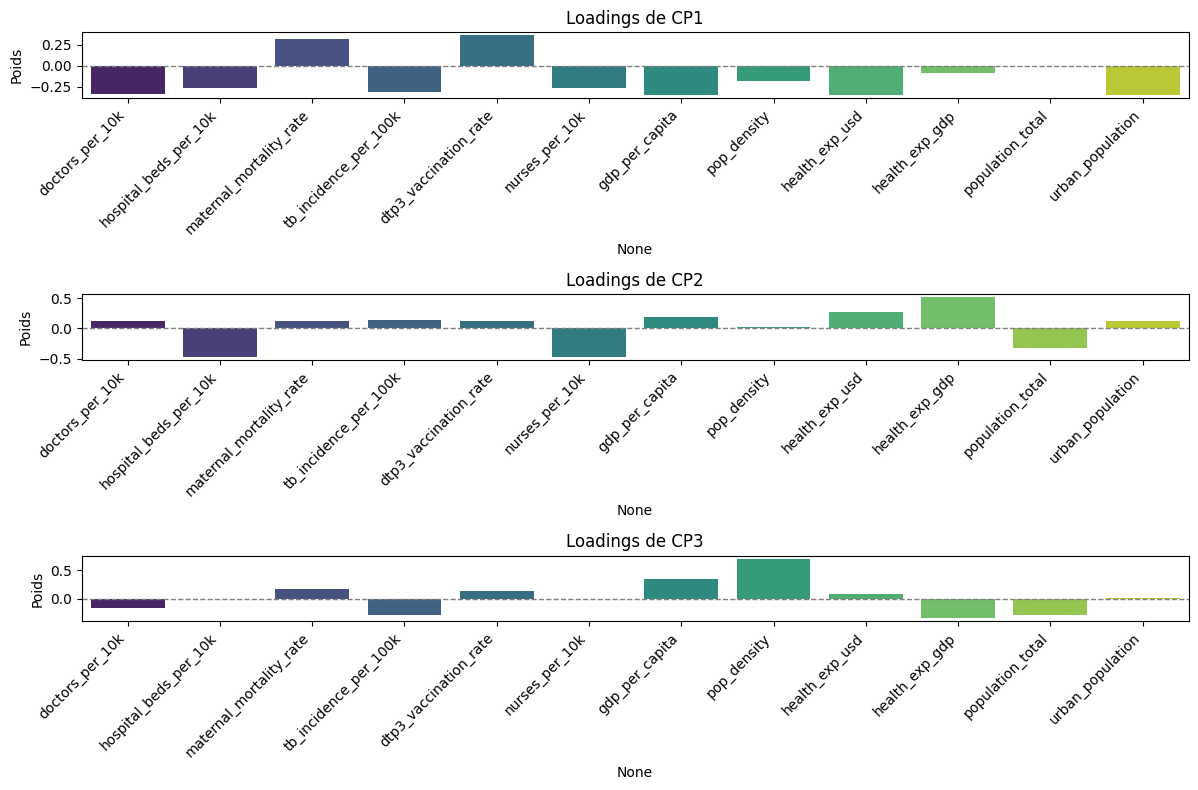

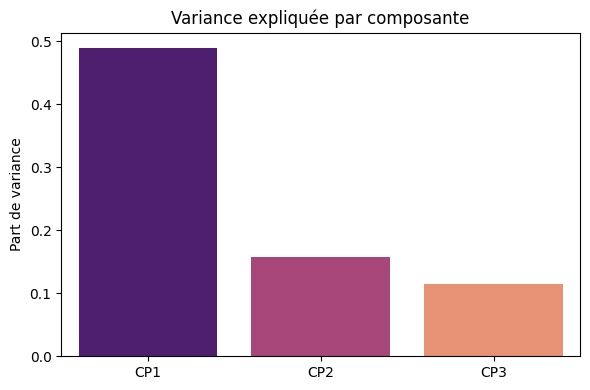

In [10]:
def prepare_panel_data_with_lags(file_path):
    """
    Crée un dataframe comprenant :
    - Country_ID (Identifiant du pays)
    - Year (Année)
    - PC1, PC2, PC3 (Composantes principales)
    - Lag_Mortality (Taux de mortalité infantile à t-1)
    - Target_Mortality (Taux de mortalité infantile à t)
    """
    df = pd.read_csv(file_path)
    
    # --- Variables pour l'ACP (12 variables excluant le taux de mortalité infantile) ---
    pca_cols = [
        'doctors_per_10k', 'hospital_beds_per_10k', 
        'maternal_mortality_rate', 'tb_incidence_per_100k', 'dtp3_vaccination_rate', 
        'nurses_per_10k', 'gdp_per_capita', 'pop_density', 'health_exp_usd', 
        'health_exp_gdp', 'population_total', 'urban_population'
    ]
    
    # Calcul de l'ACP pour toutes les années
    print("Computing PCA components for all years...")
    df = compute_pca_all_years(df, pca_cols, n_components=3)
    
    # Création de la correspondance pour l'identifiant pays (Country_ID)
    unique_countries = df['Country'].unique()
    country_id_map = {country: idx + 1 for idx, country in enumerate(sorted(unique_countries))}
    df['Country_ID'] = df['Country'].map(country_id_map)
    
    # Tri par pays et par année pour assurer un décalage correct
    df = df.sort_values(['Country', 'Year']).reset_index(drop=True)
    
    # Création de la mortalité décalée (t-1) et de la mortalité cible (t)
    df['Lag_Mortality'] = df.groupby('Country')['infant_mortality_rate'].shift(1)
    df['Target_Mortality'] = df['infant_mortality_rate']
    
    # Sélection uniquement des colonnes requises
    panel_df = df[['Country_ID', 'Year', 'PC1', 'PC2', 'PC3', 'Lag_Mortality', 'Target_Mortality']].copy()
    
    # Suppression des lignes où Lag_Mortality est NaN (première année pour chaque pays)
    panel_df = panel_df.dropna(subset=['PC1', 'PC2', 'PC3', 'Lag_Mortality', 'Target_Mortality'])
    
    print(f"\n {len(panel_df)} observations")
    print(f"Pays: {len(panel_df['Country_ID'].unique())}")
    print(f"Années: {panel_df['Year'].min()} à {panel_df['Year'].max()}")
    
    return panel_df, country_id_map


if __name__ == "__main__":
    # Chemin vers le fichier de données d’entrée
    file_path_clean = 'healthcare_data_25countries/MASTER_DATASET_CLEAN.csv'
    
    # Préparation des données de panel avec variables retardées
    panel_df, country_map = prepare_panel_data_with_lags(file_path_clean)
    
    # Save the prepared panel dataframe
    output_path = 'healthcare_data_25countries/MASTER_DATASET_PANEL_LAGS.csv'
    panel_df.to_csv(output_path, index=False)
    print(f"\nDonnées de panel générées (avec lags): {output_path}")

### 2. Modèle A : Régression linéaire à effets fixes

Le code suivant estime un modèle de régression linéaire à effets fixes afin d’analyser la relation entre la mortalité infantile cible et plusieurs variables explicatives, dont l’année et les trois composantes principales. 

Les effets fixes pays permettent de contrôler l’hétérogénéité structurelle des pays. 

Les performances du modèle sont évaluées à l’aide du R², du RMSE et d’analyses graphiques des prédictions et des résidus.


Modèle A : Régression linéaire à effets fixes
Formule: Target_Mortality ~ Year + PC1 + PC2 + PC3 + Effets fixes pays

R² (Coefficient de détermination): 0.9871
RMSE (Erreur quadratique moyenne): 1.9444

Coefficients principaux :
      Coefficient
Year    -0.470962
PC1      0.687764
PC2      2.149871
PC3      6.322750

Intercept: 1004.3027

Nombre d'effets fixes pays: 23

fig17 done


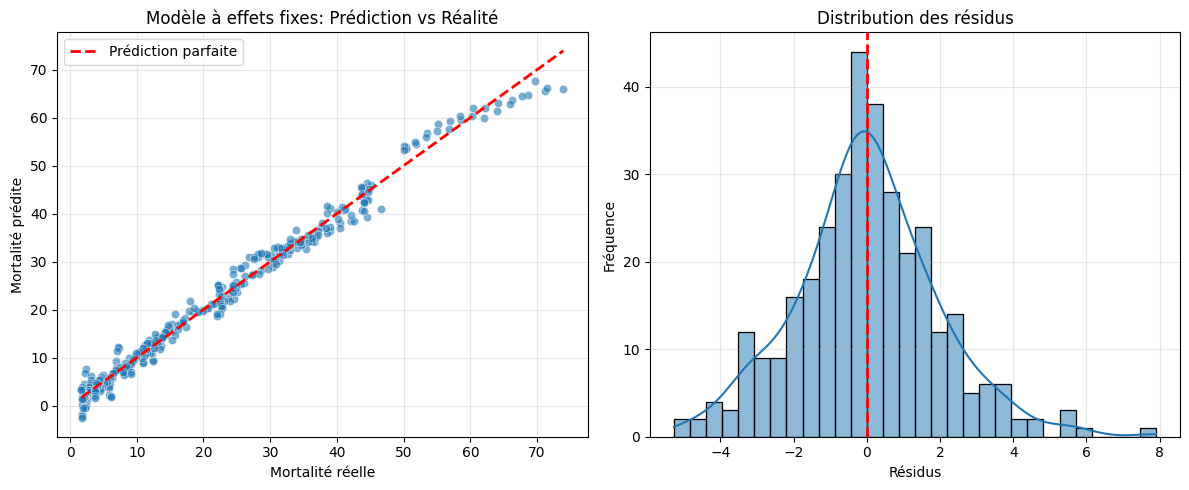

In [ ]:
def run_fixed_effects_regression(panel_df):
    """
    Modèle A : Régression linéaire à effets fixes
    Formule : Target_Mortality ~ Year + PC1 + PC2 + PC3 + Effets fixes pays
    Objectif : évaluer dans quelle mesure les composantes principales
               expliquent la mortalité cible
    """
    # Préparation des variables explicatives
    X_features = panel_df[['Year', 'PC1', 'PC2', 'PC3']].copy()
    
    # Ajout des effets fixes pays (variables muettes par pays)
    country_dummies = pd.get_dummies(panel_df['Country_ID'], prefix='Country', drop_first=True)
    
    # Combinaison des variables explicatives et des effets fixes
    X = pd.concat([X_features, country_dummies], axis=1)
    y = panel_df['Target_Mortality']
    
    # Estimation du modèle
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédictions du modèle
    y_pred = model.predict(X)
    
    # Indicateurs de performance
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    # Affichage des résultats
    print("\nModèle A : Régression linéaire à effets fixes")
    print(f"Formule: Target_Mortality ~ Year + PC1 + PC2 + PC3 + Effets fixes pays")
    print(f"\nR² (Coefficient de détermination): {r2:.4f}")
    print(f"RMSE (Erreur quadratique moyenne): {rmse:.4f}")
    
    # Coefficients des variables principales
    feature_names = ['Year', 'PC1', 'PC2', 'PC3']
    coeff_df = pd.DataFrame(
        model.coef_[:len(feature_names)],
        index=feature_names,
        columns=['Coefficient']
    )
    
    print("\nCoefficients principaux :")
    print(coeff_df)
    print(f"\nIntercept: {model.intercept_:.4f}")
    print(f"\nNombre d'effets fixes pays: {len(country_dummies.columns)}")
    
    # Visualisation
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y, y=y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2, label='Prédiction parfaite')
    plt.xlabel('Mortalité réelle')
    plt.ylabel('Mortalité prédite')
    plt.title('Modèle à effets fixes: Prédiction vs Réalité')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y - y_pred
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel('Résidus')
    plt.ylabel('Fréquence')
    plt.title('Distribution des résidus')
    plt.axvline(0, color='r', linestyle='--', linewidth=2)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('3_Exploration/Fig17_fixed_effects_regression.png', dpi=300, bbox_inches='tight')
    print("\nfig17 done")
    
    return model, coeff_df




if __name__ == "__main__":
    #Estimation du modèle de régression à effets fixes
    model_a, coefficients_a = run_fixed_effects_regression(panel_df)

Nous constatons que le modèle à effets fixes prédit assez bien la mortalité infantile. 

D'une part, le graphique de comparant les valeurs observées et prédites de la mortalité infantile montre une forte concentration des observations le long de la droite de prédiction, traduisant une bonne efficacité du modèle après la prise en compte des effets fixes par pays.

D'autre part, la distribution des résidus est globalement centrée autour de zéro et proche d’une forme normale.

Globalement, ces résultats montrent que les composantes principales et l’évolution dans le temps expliquent bien les variations de la mortalité au sein de chaque pays, une fois les différences structurelles entre pays prises en compte.

### 3. Modèle B : Régression à effets fixes avec prise en compte de la mortalité infantile en t-1

Le code suivant estime un modèle de régression linéaire à effets fixes intégrant la mortalité retardée afin de prendre en compte la persistance temporelle de la mortalité infantile au sein de chaque pays. 

Comme pour le modèle A, contrôler les effets fixes pays, permet d'isoler les variations intra-pays et d'évaluer l’apport explicatif de la mortalité passée, de la tendance temporelle et des composantes principales sur la mortalité actuelle.


Modèle B: Régression à effets fixes avec prise en compte de la mortalité infantile en t-1
Formule : Target_Mortality ~ Lag_Mortality + Year + PC1 + PC2 + PC3 + Effets fixes pays

R² (Coefficient de détermination): 0.9998
RMSE (Erreur quadratique moyenne): 0.2641

Coefficients principaux (avec lag) :
               Coefficient
Year              0.019479
PC1               0.122437
PC2               0.029763
PC3               0.175191
Lag_Mortality     0.924725

Intercept: -36.9434

Nombre d'effets fixes pays: 23

fig19 done (avec lag)


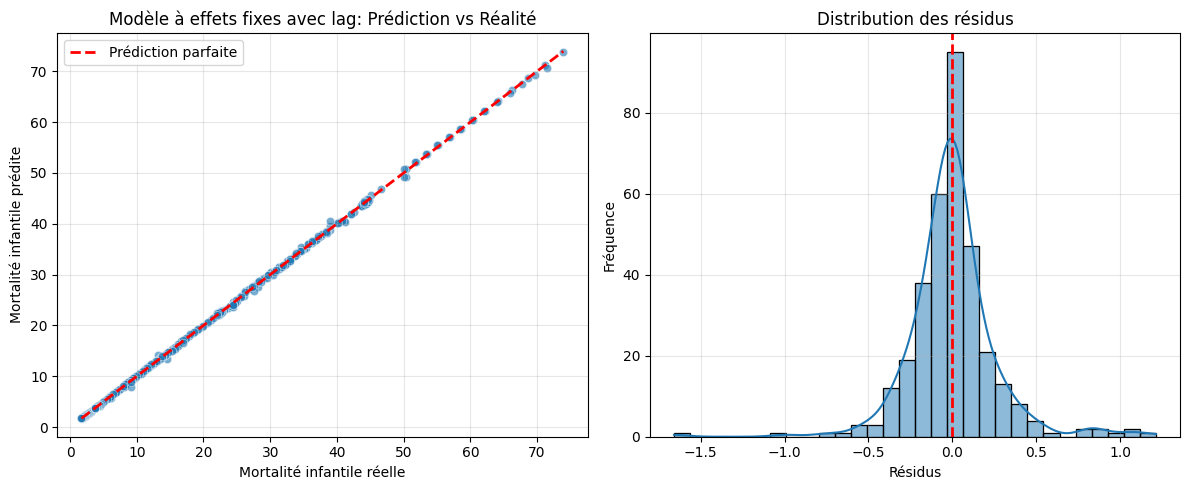

In [8]:
def run_fixed_effects_regression_with_lag(panel_df):
    """
    Modèle B : Régression à effets fixes avec prise en compte de la mortalité infantile en t-1
    Formule : Target_Mortality ~ Lag_Mortality + Year + PC1 + PC2 + PC3 + Effets fixes pays
    Objectif : prédire le taux de mortalité à partir de la mortalité passée
    et des composantes principales
    """
    # Sélection des variables explicatives
    feature_cols = ['Year', 'PC1', 'PC2', 'PC3', 'Lag_Mortality']
    X_features = panel_df[feature_cols].copy()
    
    # Ajout des effets fixes pays (variables muettes)
    country_dummies = pd.get_dummies(panel_df['Country_ID'], prefix='Country', drop_first=True)
    
    # Combinaison des variables explicatives et des effets fixes
    X = pd.concat([X_features, country_dummies], axis=1)
    y = panel_df['Target_Mortality']

    # Estimation du modèle
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    print("\nModèle B: Régression à effets fixes avec prise en compte de la mortalité infantile en t-1")
    print("Formule : Target_Mortality ~ Lag_Mortality + Year + PC1 + PC2 + PC3 + Effets fixes pays")
    print(f"\nR² (Coefficient de détermination): {r2:.4f}")
    print(f"RMSE (Erreur quadratique moyenne): {rmse:.4f}")
    
    # Coefficients des variables principales
    coeff_df = pd.DataFrame(
        model.coef_[:len(feature_cols)],
        index=feature_cols,
        columns=['Coefficient']
    )
    print("\nCoefficients principaux (avec lag) :")
    print(coeff_df)
    print(f"\nIntercept: {model.intercept_:.4f}")
    print(f"\nNombre d'effets fixes pays: {len(country_dummies.columns)}")
    
    # Visualisation
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y, y=y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2, label='Prédiction parfaite')
    plt.xlabel('Mortalité infantile réelle')
    plt.ylabel('Mortalité infantile prédite')
    plt.title('Modèle à effets fixes avec lag: Prédiction vs Réalité')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = y - y_pred
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel('Résidus')
    plt.ylabel('Fréquence')
    plt.title('Distribution des résidus')
    plt.axvline(0, color='r', linestyle='--', linewidth=2)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('3_Exploration/Fig19_fixed_effects_regression_with_lag.png', dpi=300, bbox_inches='tight')
    print("\nfig19 done (avec lag)")
    
    return model, coeff_df

if __name__ == "__main__":
    
    # Estimation du modèle à effets fixes avec variable retardée
    model_b, coefficients_b = run_fixed_effects_regression_with_lag(panel_df)




Nous constatons que, par rapport au modèle A, l’ajout de la mortalité infantile de l'année t-1 améliore nettement la qualité des prédictions.

Le modèle B reproduit presque parfaitement les niveaux observés de mortalité, ce qui montre que la mortalité passée joue un rôle déterminant dans l’évolution de la mortalité actuelle.

Les erreurs de prédiction sont plus faibles et mieux centrées autour de zéro que dans le modèle A, indiquant une meilleure prise en compte de la dynamique temporelle au sein des pays.

#### Conclusion des modèles A et B 

Finalement, les modèles de régression à effets fixes affichent une excellente capacité de prédiction, en particulier lorsque la mortalité infantile de l'année précédenten est incluse.

Cependant, ces performances reposent en grande partie sur des relations linéaires et sur une forte dépendance aux tendances passées. Ces modèles peuvent donc sous-estimer des effets non linéaires, des interactions complexes entre variables explicatives ou des ruptures de tendance.

Afin de pallier cette limite nous allons tester l'utilisation d'un modèle d’apprentissage automatique tel que XGBoost pour capturer des relations plus complexes et améliorer la capacité de généralisation.

### 4. Modèle XGBoost et comparaison avec le modèle de régression linéaire

L'objectif de cette partie est de d'appliquer un modèle d'apprentissage XGBoost et de comparer son efficacité avec les modèles de régression linéaire à effets fixes des parties précédentes.

Les codes suivants préparent les données pour appliquer le modèle XGboost et séparent les données temporelles. 
Les années jusqu’à train_end_year servent pour l’entraînement et les années à partir de test_start_year pour le test.

In [5]:
def build_features_with_fe(panel_df):
    """
    Construire la matrice de caractéristiques avec :
    - Année
    - PC1, PC2, PC3
    - Mortalité retardée
    - Effets fixes par pays (one-hot, drop_first pour éviter la colinéarité)
    """
    feature_cols = ['Year', 'PC1', 'PC2', 'PC3', 'Lag_Mortality']
    X_num = panel_df[feature_cols].copy()
    country_dummies = pd.get_dummies(panel_df['Country_ID'], prefix='Country', drop_first=True)
    X = pd.concat([X_num, country_dummies], axis=1)
    y = panel_df['Target_Mortality']
    return X, y


def walk_forward_split(panel_df, train_end_year=2020, test_start_year=2021):
    """
    Split walk forward:
    - Train: years <= train_end_year
    - Test : years >= test_start_year
    """
    train_mask = panel_df['Year'] <= train_end_year
    test_mask = panel_df['Year'] >= test_start_year

    if not train_mask.any() or not test_mask.any():
        raise ValueError("La séparation train/test est vide. Vérifiez les années dans le dataset.")

    return train_mask, test_mask

Le code suivant évalue le modèle XGBoost et le modèle de régression linéaire à effets fixes (modèle B)

Computing PCA components for all years...

ACP variance expliquée (premières 3 composantes):
  CP1: 0.4886 (48.86%)
  CP2: 0.1573 (15.73%)
  CP3: 0.1141 (11.41%)
  Cumulée: 0.7600 (76.00%)


/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/v7/pbgny3cd5w93s0mx56kgv3s80000gn/T/ipykernel_5090/2651011458.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w


 336 observations
Pays: 24
Années: 2011 à 2024


NameError: name 'XGBRegressor' is not defined

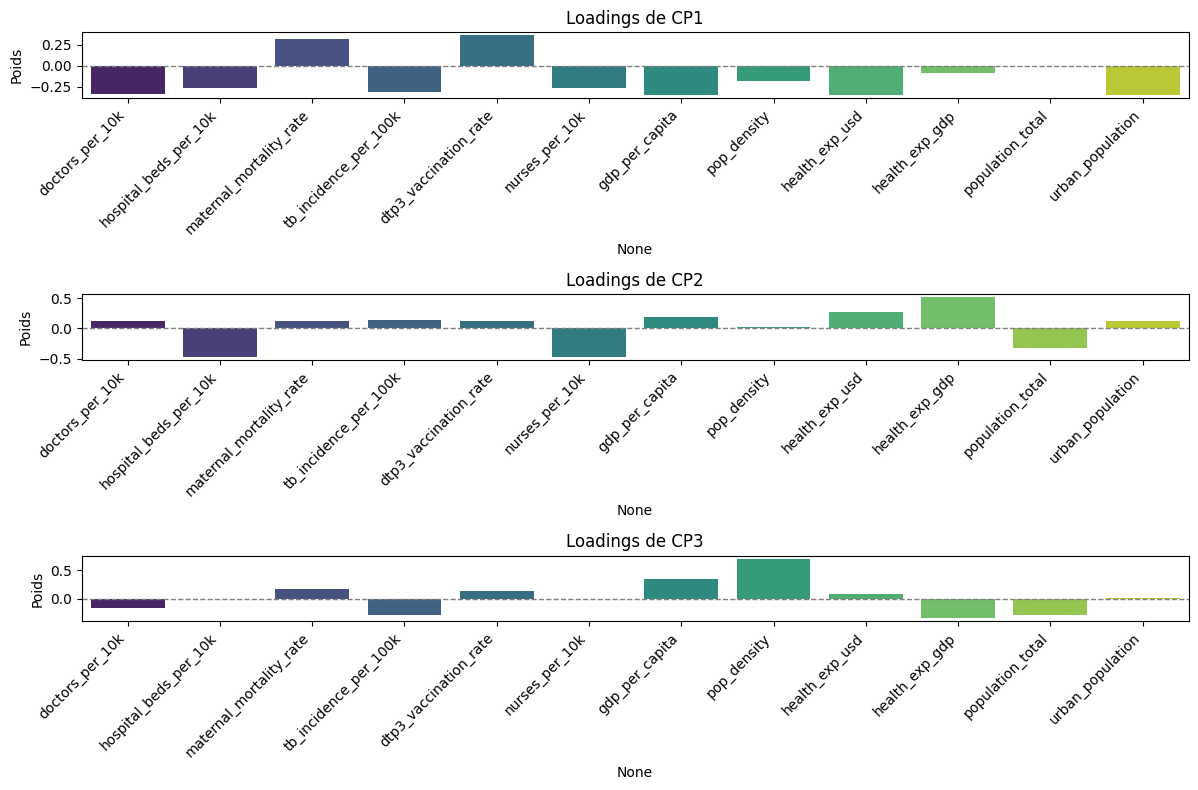

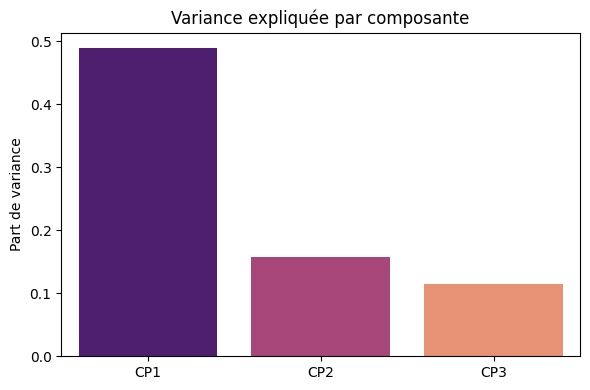

In [6]:
def evaluate_models_walk_forward(panel_df):
    """
   Compare deux modèles sur une séparation walk-forward :
    - Régression linéaire avec lag + effets fixes par pays
    - XGBoost avec les mêmes variables d'entrée
    Retourne un dictionnaire avec les RMSE et les prédictions, et sauvegarde des graphiques de comparaison.
    """
    X, y = build_features_with_fe(panel_df)
    train_mask, test_mask = walk_forward_split(panel_df, train_end_year=2020, test_start_year=2021)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Modèle 1: Régression linéaire lag + effets fixes 
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    y_pred_lin = lin_model.predict(X_test)
    rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

    # Modèle 2 : XGBoost 
    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric='rmse'
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print("\nÉvaluation walk-forward (Train: <=2020, Test: 2021-2024)")
    print(f"RMSE - Linear FE + Lag : {rmse_lin:.4f}")
    print(f"RMSE - XGBoost        : {rmse_xgb:.4f}")

    # Visualisation 
    # 1) Prédictions vs Valeurs Réelles pour les deux modèles 
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test, y=y_pred_lin, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Prédiction parfaite')
    plt.xlabel('Mortalité réelle (test)')
    plt.ylabel('Mortalité prédite (linéaire)')
    plt.title('Linéaire FE + Lag: Prédiction vs Réalité')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.7, color='orange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2, label='Prédiction parfaite')
    plt.xlabel('Mortalité réelle (test)')
    plt.ylabel('Mortalité prédite (XGBoost)')
    plt.title('XGBoost: Prédiction vs Réalité')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('4_Modelisation/Fig20_pred_vs_actual_lin_xgb.png', dpi=300, bbox_inches='tight')

    # 2) Distributions des résidus des deux modèles
    residuals_lin = y_test - y_pred_lin
    residuals_xgb = y_test - y_pred_xgb

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(residuals_lin, kde=True, bins=25, color='steelblue')
    plt.axvline(0, color='r', linestyle='--', lw=2)
    plt.xlabel('Résidus (réel - prédit)')
    plt.ylabel('Fréquence')
    plt.title('Résidus - Linéaire FE + Lag')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.histplot(residuals_xgb, kde=True, bins=25, color='orange')
    plt.axvline(0, color='r', linestyle='--', lw=2)
    plt.xlabel('Résidus (réel - prédit)')
    plt.ylabel('Fréquence')
    plt.title('Résidus - XGBoost')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('4_Modelisation/Fig21_residuals_lin_xgb.png', dpi=300, bbox_inches='tight')

    return {
        'rmse_linear_fe_lag': rmse_lin,
        'rmse_xgboost': rmse_xgb,
        'y_test': y_test,
        'y_pred_lin': y_pred_lin,
        'y_pred_xgb': y_pred_xgb,
    }


if __name__ == "__main__":
    file_path_clean = 'healthcare_data_25countries/MASTER_DATASET_CLEAN.csv'

    panel_df, _ = prepare_panel_data_with_lags(file_path_clean)

    # Évaluation des modèles sur la séparation walk-forward (2010-2020 entrainement, 2021-2024 test)
    evaluate_models_walk_forward(panel_df)

Nous constatons que le modèle XGBoost présente une dispersion légèrement plus marquée que le modèle de regréssion linéaire à effets fixes (modèle B), notamment pour les valeurs de mortalité infantile les plus élevées où il a tendance à sous-estimer légèrement la réalité. 

D'autre part le modèle linéaire, les résidus sont proches de zéro et assez réguliers, avec seulement quelques valeurs un peu plus grandes, ce qui montre que le modèle se trompe rarement mais peut sous-estimer certains points. 
Pour XGBoost, les résidus sont plus dispersés et certains sont beaucoup plus grands, ce qui indique que le modèle fait quelques grosses erreurs, même s’il capture mieux la complexité des données.

Finalement le modèle linéaire semble produire des résidus plus concentrés et plus symétriques, tandis que XGBoost capture mieux la complexité des données mais au prix de quelques erreurs plus importantes. 

Les erreurs de prédiction des valeurs de mortalité infantile les plus élevées peuvent être dues à la structure du jeu de données. En effet, les valeurs de mortalité infantile très élevée sont rares dans le jeu de données, donc le modèle dispose de peu d'exemples sur lesquels s'entrainer. Pour ces valeurs il peut donc avoir tendance à se recentrer vers la moyenne, sous estimant les valeurs extrêmes. 
